In [1]:
# General 
import json
import os
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns;

# Natural Language Toolkit 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
# Additional functionality:
#import nltk
#nltk.download()

# Classification / Visualization
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# Neural Networks (not used)
#import tensorflow as tf
#tf.random.set_seed(0)

In [2]:
# retrieve data from multiple .json files and convert to csv
f = open("Project_Data/tossups.csv", "w", encoding="utf-8")
f.write("Question,Answer,Category,Subcategory\n")

directory = "Project_Data/Subcategory_Data/"
for filename in os.listdir(directory): 
    # Opening JSON file
    f2 = open(directory + filename, encoding="utf-8")
    # returns JSON object as a dictionary
    data = json.load(f2)
    f2.close()
    for tossup in data['data']['tossups']:
        question = tossup['text']
        question = question.replace(",","")
        answer = tossup['answer']
        answer = answer.replace(",","")
        category = tossup['category_id']
        subcategory = tossup['subcategory_id']
        if subcategory == None:
            subcategory = -1
        # need to give new subcategories values because there is overlap with category and subcategory 
        # 14 myth...................3
        # 20 geography..............6
        # 25 philosophy.............7
        # 22 social science.........9
        if category == 19:
            subcategory = 19
        if category == 14:
            subcategory = 3
        if category == 20:
            subcategory = 6
        if category == 25:
            subcategory = 7
        if category == 22:
            subcategory = 9
        if category != None:
            f.write(question + "," + answer + "," + str(category) + "," + str(subcategory) + "\n")
f.close()

In [3]:
# load csv into dataframe
tossups = pd.read_csv('Project_Data/tossups.csv')

In [4]:
# remove any na columns and double check
tossups = tossups.dropna()
tossups.isna().sum()

Question       0
Answer         0
Category       0
Subcategory    0
dtype: int64

In [5]:
# examine dataframe
tossups.head()

,Question,Answer,Category,Subcategory
0,One piece in this genre and number was played ...,ninth symphonies [accept obvious equivalents ...,21.0,8.0
1,A composer from this country quoted themes fro...,People’s Republic of China [or Zhōngguó or Zhō...,21.0,8.0
2,This composer imitated J. S. Bach in writing a...,Dmitri Shostakovich [or Dmitri Dmitriyevich Sh...,21.0,8.0
3,Leoš Janáček’s (LAYH-osh YAH-nah-check’s) corr...,string quartet [prompt on quartet or string mu...,21.0,8.0
4,A song titled after this musician oddly transi...,Duke Ellington &lt;Jazz — French&gt; [Edited],21.0,8.0


In [6]:
# Category and subcategory labels as defined by QuizDB

# 25 philosophy
# 22 social science
# 21 fine arts
    # audio 8
    # visual 2
    # other 25
# 20 geography
# 19 religion
# 18 - history
    # american 13
    # classical 16
    # european 24
    # world 20
# 17-science
    # chem 5
    # bio 14
    # phys 18
    # math 26
# 15 lit
    # american 4
    # british 22
    # european 1
    # world 12
# 14 myth

# Relabeled subcategories to avoid duplicates:
# 14 myth...................3
# 20 geography..............6
# 25 philosophy.............7
# 22 social science.........9

# ascending by category
class_names = ['Myth', 'Literature','Science', 'History', 'Religion', 'Geography', 'Fine Arts', 'Social Science', 'Pihlosophy']

# index = category
class_index = ['', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Myth', 'Literature','', 'Science', 'History',
               'Religion', 'Geography', 'Fine Arts', 'Social Science', '', '', 'Philosophy']

# ascending by subcategory
sub_class_names = ['lit_euro', 'fa_visual', 'myth', 'lit_amer', 'sci_chem', 'geo', 'phil', 'fa_audio', 'soc_sci', 'lit_world', 'hist_amer',
                   'sci_bio', 'hist_class', 'sci_phys', 'rlgn', 'hist_world', 'lit_brit', 'hist_euro', 'fa_other', 'sci_math']

# index = subcategory
sub_class_index = [ '', 'Literature: European', 'Fine Arts: Visual', 'Mythology', 'Literature: American',
                   'Science: Chemistry', 'Geography', 'Philosophy', 'Fine Arts: Audio', 'Social Science',
                  '', '', 'Literature: World', 'History: American', 'Science: Biology',
                  '', 'History: Classical', '', 'Science: Physics', 'Religion',
                  'History: World', '', 'Literature: British', '', 'History: European',
                  'Fine Arts: Other', 'Science: Math']

# use when only analyizing literature, history, and science
# class_names_big3 = ['Literature','Science', 'History']
# sub_class_names_big3 = ['lit_euro', 'lit_amer', 'sci_chem', 'lit_world', 'hist_amer', 'sci_bio', 'hist_class', 'sci_phys', 'hist_world', 'lit_brit', 'hist_euro', 'sci_math']

# Getting only history, lit, and science dataframe
# big3 = tossups.loc[(corpus['Category'] == 18) | (corpus['Category'] == 17) | (corpus['Category'] == 15)]

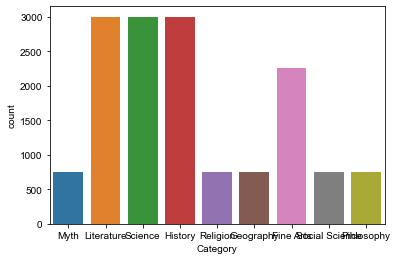

In [7]:
# plot of number of questions by category
ax = sns.countplot(x=tossups['Category']); 
ax.set_xticklabels(class_names)
sns.set(rc={'figure.figsize':(10,15)})
plt.show()

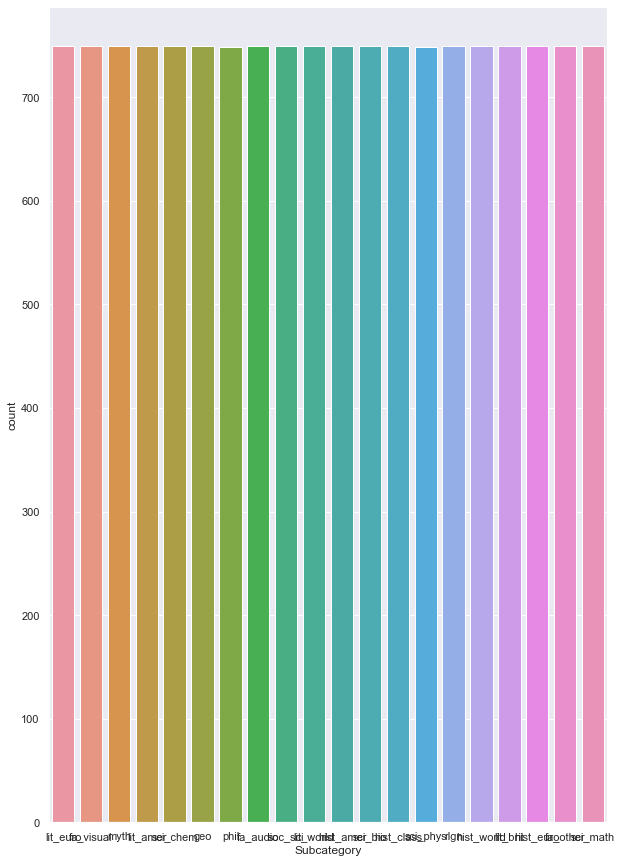

In [8]:
# plot number of questions by subcategory
ax = sns.countplot(x=tossups['Subcategory']); 
ax.set_xticklabels(sub_class_names)
plt.show()

In [9]:
# function to convert raw text into tokens
tokenizer      =  word_tokenize
stop_words     = set(stopwords.words('english'))
wnl            = WordNetLemmatizer()

def cleanText(raw_text): #tokenize, lowercase, remove stopwords, removePunctuation, lemmatize
    tokens         = tokenizer(raw_text)                                #step 1    
    tokens         = [ word.lower() for word in tokens ]                #step 2
    tokens         = [ w for w in tokens if not w in stop_words ]       #step 3
    tokens         = [ w for w in tokens if w.isalpha() ]               #step 4
    tokens         = [ wnl.lemmatize ( t ) for t in tokens ]            #step 5
#     text           = ' '.join(tokens)
    return tokens

In [10]:
# cleaning/processing the text; this can take a few minutes
tossups['clean_Question']  = tossups.Question.map(lambda x: ' '.join(cleanText(x)))

In [11]:
# assign the cleaned questions to X, and the subcategory labels to y
X = tossups['clean_Question']
y = tossups['Subcategory']

## Visualization

In [12]:
# fit and transform TfidfVectorizer
tfidf    = TfidfVectorizer(lowercase=False) #lowercase=False because words were already made lowercase during clean function
X_tfs_vecs   = tfidf.fit_transform(X)

# use tfidf vector on t-SNE algorithm
X_VEC_TSNE = TSNE(n_components = 2).fit_transform(X_tfs_vecs)

C:\Users\ryzes\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ryzes\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [13]:
# create arrays for t-SNE projection below
hist_amer = y== 13
hist_class = y==16
hist_euro = y== 24
hist_world = y==20
sci_chem = y==5
sci_bio = y==14
sci_phys = y==18
sci_math = y==26
lit_amer = y==4
lit_brit = y==22
lit_euro = y==1
lit_world = y==12
myth = y==3
phil = y==7
soc_sci = y==9
fa_vis = y==2
fa_audio = y==8
fa_other = y==25
geo = y==6
rlgn = y==19

### t-SNE projection for big 3 categories

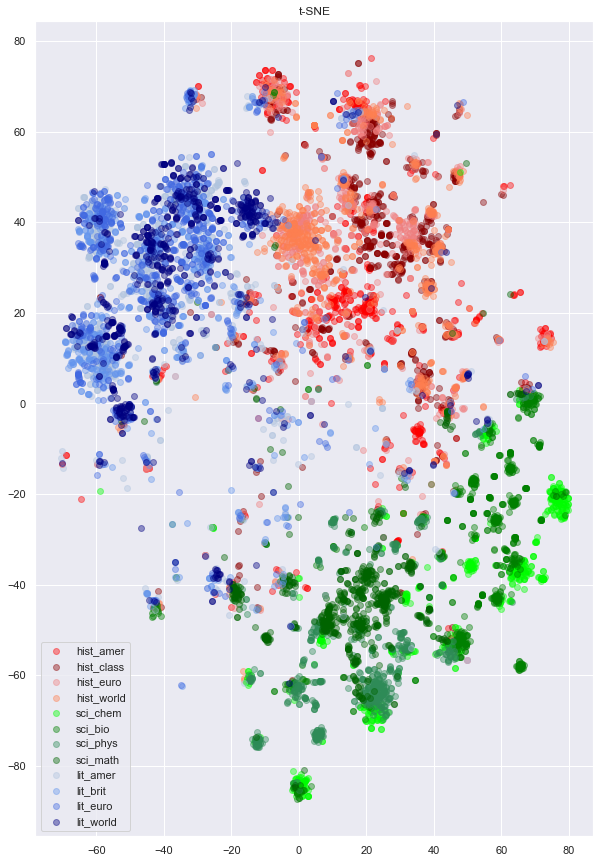

In [14]:
# visualize the vectorized training data using t-SNE projection
plt.scatter(X_VEC_TSNE[hist_amer,0], X_VEC_TSNE[hist_amer,1], label="hist_amer", color="red", alpha=0.4)
plt.scatter(X_VEC_TSNE[hist_class,0], X_VEC_TSNE[hist_class,1], label="hist_class", color="darkred", alpha=0.4)
plt.scatter(X_VEC_TSNE[hist_euro,0], X_VEC_TSNE[hist_euro,1], label="hist_euro", color="lightcoral", alpha=0.4)
plt.scatter(X_VEC_TSNE[hist_world,0], X_VEC_TSNE[hist_world,1], label="hist_world", color="coral", alpha=0.4)

plt.scatter(X_VEC_TSNE[sci_chem,0], X_VEC_TSNE[sci_chem,1], label="sci_chem", color="lime", alpha=0.4)
plt.scatter(X_VEC_TSNE[sci_bio,0], X_VEC_TSNE[sci_bio,1], label="sci_bio", color="green", alpha=0.4)
plt.scatter(X_VEC_TSNE[sci_phys,0], X_VEC_TSNE[sci_phys,1], label="sci_phys", color="seagreen", alpha=0.4)
plt.scatter(X_VEC_TSNE[sci_math,0], X_VEC_TSNE[sci_math,1], label="sci_math", color="darkgreen", alpha=0.4)

plt.scatter(X_VEC_TSNE[lit_amer,0], X_VEC_TSNE[lit_amer,1], label="lit_amer", color="lightsteelblue", alpha=0.4)
plt.scatter(X_VEC_TSNE[lit_brit,0], X_VEC_TSNE[lit_brit,1], label="lit_brit", color="cornflowerblue", alpha=0.4)
plt.scatter(X_VEC_TSNE[lit_euro,0], X_VEC_TSNE[lit_euro,1], label="lit_euro", color="royalblue", alpha=0.4)
plt.scatter(X_VEC_TSNE[lit_world,0], X_VEC_TSNE[lit_world,1], label="lit_world", color="navy", alpha=0.4)

plt.title("t-SNE")
sns.set(rc={'figure.figsize':(10,5)})
plt.legend()

### t-SNE projection of all subcategories

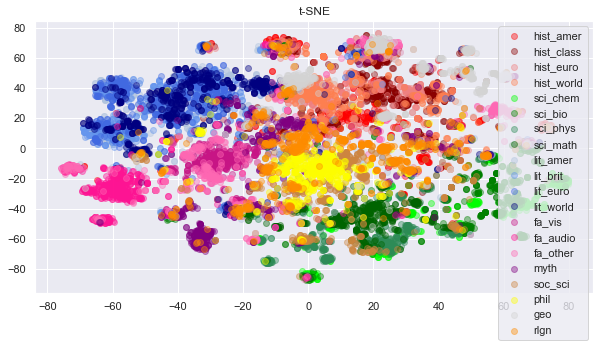

In [15]:
# visualize the vectorized training data using t-SNE projection
plt.scatter(X_VEC_TSNE[hist_amer,0], X_VEC_TSNE[hist_amer,1], label="hist_amer", color="red", alpha=0.4)
plt.scatter(X_VEC_TSNE[hist_class,0], X_VEC_TSNE[hist_class,1], label="hist_class", color="darkred", alpha=0.4)
plt.scatter(X_VEC_TSNE[hist_euro,0], X_VEC_TSNE[hist_euro,1], label="hist_euro", color="lightcoral", alpha=0.4)
plt.scatter(X_VEC_TSNE[hist_world,0], X_VEC_TSNE[hist_world,1], label="hist_world", color="coral", alpha=0.4)

plt.scatter(X_VEC_TSNE[sci_chem,0], X_VEC_TSNE[sci_chem,1], label="sci_chem", color="lime", alpha=0.4)
plt.scatter(X_VEC_TSNE[sci_bio,0], X_VEC_TSNE[sci_bio,1], label="sci_bio", color="green", alpha=0.4)
plt.scatter(X_VEC_TSNE[sci_phys,0], X_VEC_TSNE[sci_phys,1], label="sci_phys", color="seagreen", alpha=0.4)
plt.scatter(X_VEC_TSNE[sci_math,0], X_VEC_TSNE[sci_math,1], label="sci_math", color="darkgreen", alpha=0.4)

plt.scatter(X_VEC_TSNE[lit_amer,0], X_VEC_TSNE[lit_amer,1], label="lit_amer", color="lightsteelblue", alpha=0.4)
plt.scatter(X_VEC_TSNE[lit_brit,0], X_VEC_TSNE[lit_brit,1], label="lit_brit", color="cornflowerblue", alpha=0.4)
plt.scatter(X_VEC_TSNE[lit_euro,0], X_VEC_TSNE[lit_euro,1], label="lit_euro", color="royalblue", alpha=0.4)
plt.scatter(X_VEC_TSNE[lit_world,0], X_VEC_TSNE[lit_world,1], label="lit_world", color="navy", alpha=0.4)

plt.scatter(X_VEC_TSNE[fa_vis,0], X_VEC_TSNE[fa_vis,1], label="fa_vis", color="mediumvioletred", alpha=0.4)
plt.scatter(X_VEC_TSNE[fa_audio,0], X_VEC_TSNE[fa_audio,1], label="fa_audio", color="deeppink", alpha=0.4)
plt.scatter(X_VEC_TSNE[fa_other,0], X_VEC_TSNE[fa_other,1], label="fa_other", color="hotpink", alpha=0.4)

plt.scatter(X_VEC_TSNE[myth,0], X_VEC_TSNE[myth,1], label="myth", color="purple", alpha=0.4)

plt.scatter(X_VEC_TSNE[soc_sci,0], X_VEC_TSNE[soc_sci,1], label="soc_sci", color="peru", alpha=0.4)

plt.scatter(X_VEC_TSNE[phil,0], X_VEC_TSNE[phil,1], label="phil", color="yellow", alpha=0.4)

plt.scatter(X_VEC_TSNE[geo,0], X_VEC_TSNE[geo,1], label="geo", color="lightgray", alpha=0.4)

plt.scatter(X_VEC_TSNE[rlgn,0], X_VEC_TSNE[rlgn,1], label="rlgn", color="darkorange", alpha=0.4)

plt.title("t-SNE")
sns.set(rc={'figure.figsize':(10,15)})
plt.legend()

### t-SNE with Count Vectorizer (Not exactly what we want)

In [16]:
# vectorizer = CountVectorizer(stop_words='english').fit(X)
# X_VEC = vectorizer.transform(X)

In [17]:
# #compute TSNE
# perplexity = 60
# tsne = TSNE(random_state=0, perplexity=perplexity)
# tsne_proj = tsne.fit_transform(X_VEC)

In [18]:
# # tsne projection
# plt.scatter(tsne_proj[hist_amer,0], tsne_proj[hist_amer,1], label="hist_amer", color="red", alpha=0.4)
# plt.scatter(tsne_proj[hist_class,0], tsne_proj[hist_class,1], label="hist_class", color="darkred", alpha=0.4)
# plt.scatter(tsne_proj[hist_euro,0], tsne_proj[hist_euro,1], label="hist_euro", color="lightcoral", alpha=0.4)
# plt.scatter(tsne_proj[hist_world,0], tsne_proj[hist_world,1], label="hist_world", color="coral", alpha=0.4)

# plt.scatter(tsne_proj[sci_chem,0], tsne_proj[sci_chem,1], label="sci_chem", color="lime", alpha=0.4)
# plt.scatter(tsne_proj[sci_bio,0], tsne_proj[sci_bio,1], label="sci_bio", color="green", alpha=0.4)
# plt.scatter(tsne_proj[sci_phys,0], tsne_proj[sci_phys,1], label="sci_phys", color="seagreen", alpha=0.4)
# plt.scatter(tsne_proj[sci_math,0], tsne_proj[sci_math,1], label="sci_math", color="darkgreen", alpha=0.4)

# plt.scatter(tsne_proj[lit_amer,0], tsne_proj[lit_amer,1], label="lit_amer", color="lightsteelblue", alpha=0.4)
# plt.scatter(tsne_proj[lit_brit,0], tsne_proj[lit_brit,1], label="lit_brit", color="cornflowerblue", alpha=0.4)
# plt.scatter(tsne_proj[lit_euro,0], tsne_proj[lit_euro,1], label="lit_euro", color="royalblue", alpha=0.4)
# plt.scatter(tsne_proj[lit_world,0], tsne_proj[lit_world,1], label="lit_world", color="navy", alpha=0.4)

# plt.title("t-SNE")
# sns.set(rc={'figure.figsize':(10,5)})
# plt.legend()

## Naive Bayes Classification

### By Category

In [19]:
# assign data to X and y and perform train/test split
X = tossups['clean_Question']
y = tossups['Category']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3, random_state=325)

In [20]:
# define pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()), #define our vectorizer
    ('clf', MultinomialNB()),      #define our classifier
])

# define parameters
# Note: Parameters of pipelines can be set using '__' separated parameter names
parameters = {
    'tfidf__min_df': (0,   0.001),
    'tfidf__max_df': (0.5, 1.0),
    'tfidf__max_features': [1000, None],
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
}

# use GridSearchCV
grid = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=2, cv=3);

In [21]:
# Fit gridsearch to find best parameters
grid.fit(X_train,y_train);

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [22]:
print("Best Score: ", grid.best_score_)
print("Best Params: ", grid.best_params_)

Best Score:  0.8893119666843589
Best Params:  {'tfidf__max_df': 0.5, 'tfidf__max_features': 1000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 2)}


In [23]:
# evaluate the performance
model = grid.best_estimator_
y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print("Accuracy : {} %".format(round(acc*100, 2)))

Accuracy : 90.04 %


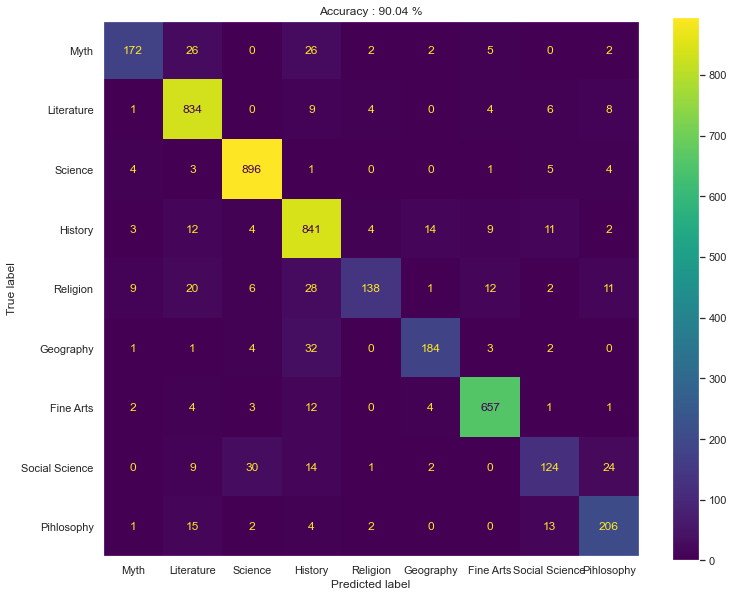

In [24]:
# plot the confusion matrix
fig,ax = plt.subplots(1,1,figsize=(12, 10))
cmd=ConfusionMatrixDisplay(cm, display_labels=class_names) 
cmd.plot(ax=ax)
plt.title("Accuracy : {} %".format(round(acc*100, 2)))
plt.grid(False)
plt.show()

In [25]:
#https://datascience.stackexchange.com/questions/37899/sklearn-svm-how-to-get-a-list-of-the-wrong-predictions
# Access questions that were incorrectly classified
for row_index, (input, prediction, label) in enumerate(zip (X_test, y_pred, y_test)):
  if prediction != label:
    print('Row', row_index, 'has been classified as', class_index[int(prediction)], 'and should be', class_index[int(label)])
    print('Questions: ' + input + '\n')

Row 0 has been classified as Science and should be Social Science
Questions: irene heim dissertation property equated file change potential ray jackendoff mentalist postulate hold property resides lexical conceptual property represented set namesake postulate intensional logic montague grammar entire sentence property simply function constituent value according principle compositionality noam chomsky noted sentence colorless green idea sleep furiously lack property even though syntactically single lexical item corresponds one property polysemy homonymy point give term expressive content word sentence studied semantics

Row 12 has been classified as Literature and should be Social Science
Questions: letter appears hyphen name constructed language kenneth pike devised teach art translation theory named letter extended government binding theory ipa letter represents voiceless velar fricative noam chomsky argued language share underlying structure intermediate node phrase symbolized apostr

Row 2205 has been classified as Geography and should be History
Questions: garrison troop stationed island body water inducted first black freemason led prince hall order response military action body water sympathetic legislator led robert carter nicholas introduced bill proposing day fasting held june island within body water used detain native forcibly removed praying town natick inhabitant dedham grant large amount bohea ended body water event whose planner met green dragon tavern anonymous play titled blockhead written possibly mercy otis warren body water blockaded term port act passed lord north government along intolerable act point name body water december son liberty held tea party

Row 2217 has been classified as Social Science and should be Philosophy
Questions: primacy politics sheri berman analyzed marcel deát thinker surname exemplar tendency sort theorist adopt national socialism trend french socialism julian jackson call planomania inspired thinker last name plan du tr

Row 3681 has been classified as Literature and should be Myth
Questions: diotima declares figure son contrivance poverty story male figure told old woman comfort charite beginning book four golden as brother anteros complains mother theocritus poem stung bee called protogenos firstborn reference possible parentage either chaos uranus gaia upon convinced god malicious serpent lover spill candle oil trying see face father hedone lover completes four trial appease mother venus point name lover psyche love god us bow

Row 3704 has been classified as Fine Arts and should be History
Questions: describing act committed building delphin delmas popularized term dementia americana charles atlas rose fame dubbed world perfectly developed man physical culture contest building action building prompted trial covered ada patterson female journalist nicknamed sob sister reported testimony red velvet man fatally shot building rooftop performance mam zelle champagne destruction another building construc

### By Subcategory

In [26]:
# splitting into train and test for SUBCATEGORY
X = tossups['clean_Question']
y = tossups['Subcategory']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3, random_state=325)

In [27]:
#define pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()), #define our vectorizer
    ('clf', MultinomialNB()),      #define our classifier
])

#define parameters
parameters = {
    'tfidf__min_df': (0,   0.001),
    'tfidf__max_df': (0.5, 1.0),
    'tfidf__max_features': [1000, None],
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
}

#use GridSearchCV
grid = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3);

In [28]:
grid.fit(X_train,y_train);

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [29]:
print("Best Score: ", grid.best_score_)
print("Best Params: ", grid.best_params_)

Best Score:  0.8235853236979273
Best Params:  {'tfidf__max_df': 1.0, 'tfidf__max_features': None, 'tfidf__min_df': 0, 'tfidf__ngram_range': (1, 1)}


In [30]:
# evaluate the performance
model = grid.best_estimator_
y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print("Accuracy : {} %".format(round(acc*100, 2)))

Accuracy : 84.82 %


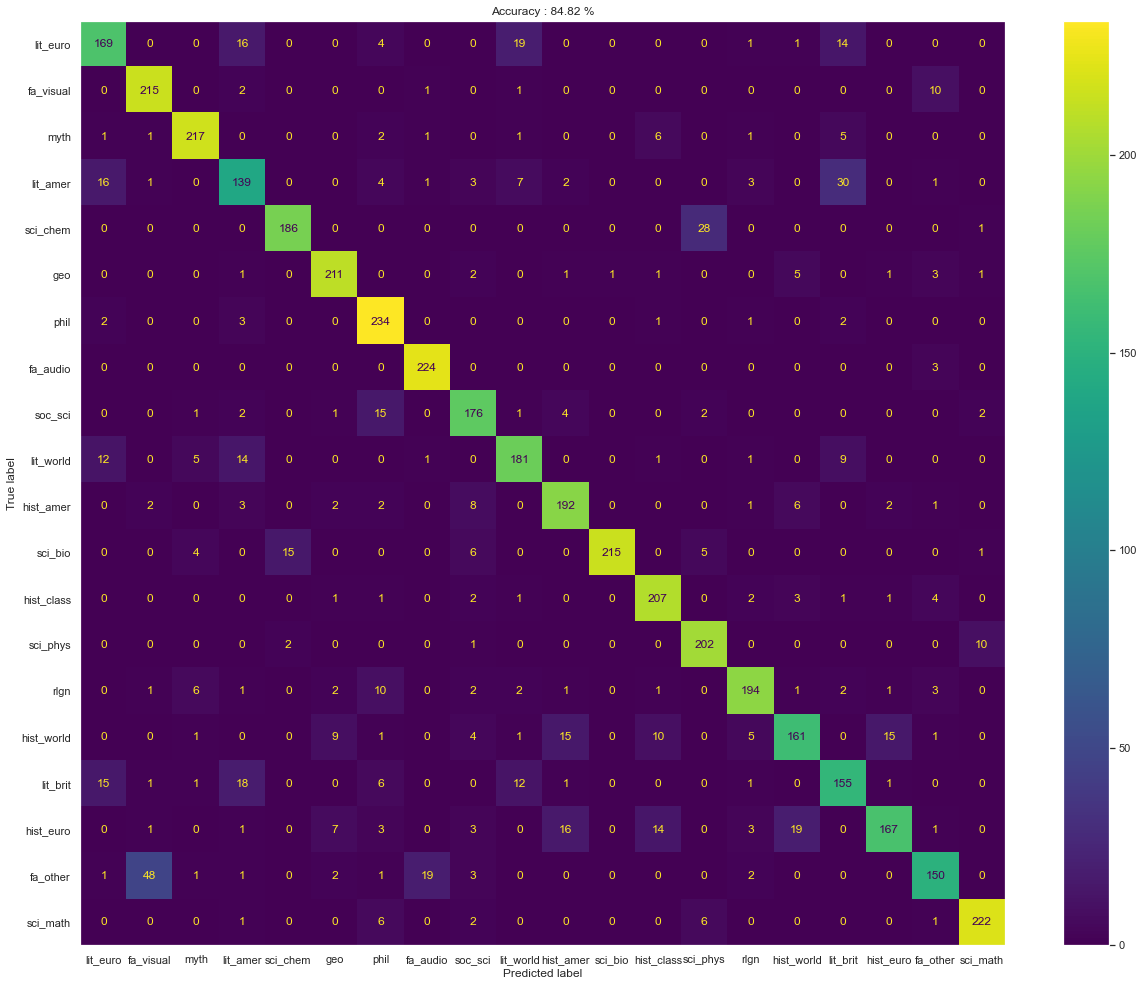

In [31]:
fig,ax = plt.subplots(1,1,figsize=(21, 17))
cmd=ConfusionMatrixDisplay(cm, display_labels=sub_class_names) 
cmd.plot(ax=ax)
plt.title("Accuracy : {} %".format(round(acc*100, 2)))
plt.grid(False)
plt.show()

In [32]:
# Gets the most important features (words), but I think there is an issue with it
# def getMostImportantFeaturesNB(clf,tfidf,N=20):
#     feature_names = tfidf.get_feature_names()
#     nclasses      = clf.feature_log_prob_.shape[0]
#     clf.feature_log_prob_.shape
#     features      = []
#     for i in range(nclasses):
#         feature_prob  = (clf.feature_log_prob_[i]) #class i
#         indices       = np.argsort(np.abs(feature_prob))[::-1]
#         features_i    = []
#         for j in range(N):
#             features_i.append(feature_names[indices[j]])
#         features.append(features_i)
#     for i in range(nclasses):
#         print("class %d important features"%i)
#         print(features[i])

In [33]:
# getMostImportantFeaturesNB(model[1], model[0])

In [34]:
# Classifies a list of tossups given the tfidf and classifier
def classifyTossup(raw_text,tfidf,clf): #tfidf is our vectorizer, clf is our classifier
    clean_text = [cleanText(rt) for rt in raw_text] #important to prepare data the same way
    clean_text = [' '.join(text) for text in clean_text] # changes from a list to string
    tfs_vecs   = tfidf.transform(clean_text) #must just be transform, don't re-fit
    tfidf_data = tfs_vecs.toarray()
    y_pred     = clf.predict(tfidf_data)
    y_prob     = clf.predict_proba(tfidf_data)
    out        = [(sub_class_index[int(c)], c, round(p.max(),4)) for c,p in zip(y_pred,y_prob)]   #get class and probability
    print("Predicted Subcategory, Subcategory Label, Probability")
    for o in out:
        print(o)

In [35]:
# List of test tossups to evaluate performance. The correct subcategory is commented above each

# 9 Social Science
tossup1 = 'This thinker determined that Sergei Pankejeff’s vision of six white wolves on a tree was caused by an “infantile neurosis.” Activities like breastfeeding and strict potty training could lead to “fixations” later in life in this thinker’s five-stage model of development. This thinker proposed the (*) “manifest content” is a censored version of the much more sexual and violent “latent content” in his work The Interpretation of Dreams. This thinker proposed that the primal, animalistic desires of the id are regulated by the superego. For 10 points, name this pseudoscientific Austrian psychologist who founded the field of psychoanalysis.'
# 13 American History
tossup2 = 'A speech by this leader compares its subject to Passover and to a “ring-bolt in the chain of your yet undeveloped destiny.” One of this leader’s publications bore a slogan ending “God is the Father of us all, and we are all brethren.” This leader fought “the snake” Edward Covey to a draw after learning how to read from Sophia Auld. This man declared that the title (*) holiday is “yours, not mine” in his Fourth of July Speech. This leader, who gave a decisive speech in favor of the women’s suffrage resolution at Seneca Falls, published the newspaper North Star. For 10 points, name this author of narratives like My Bondage and My Freedom describing his life as a slave.'
#18 Physics
tossup3 = 'A bar being dragged down a metal rail by a constant external force may have an exponential decrease in its velocity because of this law. This equation explains how skin and proximity effects create eddies that heat up metals. A commutator and a rotating solenoid are used to generate power in a common application of this equation. This law gives the magnitude of the step-up or step-down in voltage from a (*)) transformer. This law has a minus sign as a consequence of Lenz\'s law. It sets the electromotive force equal to the negative time derivative of the B flux through a current loop. For 10 points, name this equation giving the induced voltage from a change in magnetic field, the only one of Maxwell\'s equations named for an English scientist.'
# 5 (easy) Chemistry
tossup4 = ' A “bog” variety of this element can be created via the purification of goethite (GUR-tite). Sedimentary rocks dating back to the Precambrian contain banded formations of this element that formed during the Great Oxygenation Event. Elements which sink into the core, such as gold and palladium, are known as (*) siderophiles due to their affinity for this element. The most common ore of this element is the reddish-brown hematite, and it can be found with sulfur in the mineral pyrite. Along with nickel, this element composes a majority of the Earth’s core. For 10 points, name this metal whose oxide forms rust.'
# 5 (hard) Chemistry
tossup5 = 'One form of this technique traps small molecules in pores of an adsorbent material such as polystyrene. In another form of this technique, a sample passes through a flame ionization detector after passing through a “carrier gas” such as helium. One form of this technique pumps a sample through a column filled with an adsorbent material using a solvent at a very high pressure. In this technique, the (*) retention factor characterizes the distance travelled by a given compound. This technique uses a mobile phase to carry a mixture up the stationary phase, and it is often demonstrated using paper. For 10 points, name this technique named for the colored patterns formed by separating compounds.'
# 3 Myth
tossup6 = "As a rite of passage, Spartan boys were flogged in the sanctuary to this deity in Orthia. This deity drove Polyphonte back home to her father after Polyphonte had sex with a bear. This deity ran between two giants so that they killed each other with javelins. Because this deity sent unfavorable winds to prevent Agamemnon’s fleet from leaving Aulis, Agamemnon (*) sacrificed his daughter Iphigenia to appease this deity. This goddess sent the Calydonian Boar to ravage Aetolia, and she transformed Actaeon into a stag after he watches her bathe. This goddess was birthed by Leto on the floating island of Delos alongside her twin brother Apollo. For 10 points, name this Greek goddess of the hunt"
# 8 Fine Arts Audio
tossup7 = 'After attending a lecture by this author, Leos Janacek composed a chorus for men\'s voices based on this author\'s work, titled "The Wandering Madman." Rued Langgaard composed a suite of ten hymns named for this author\'s major poetry collection, which also inspired songs for voice and piano by John Alden Carpenter such as "On the seashore of endless worlds." This author represents the present, along with Tolstoy and Martin Luther King, Jr.\'s "past" and "future," and advises Mahatma Gandhi in the second act of Philip Glass\' opera Satyagraha. His compositions include the music and libretto of "Jana Gana Mana," adopted as India\'s national anthem. For 10 points, name this Bengali poet of Gitanjali.'
# 20 World Literature
tossup8 = 'A poem by this author opens by describing “endless worlds where children meet.” An essay claims that “poetry and religion are the same thing” for this author and compares him to those children because “they know not how to cast nets.” This poet discussed a place where “knowledge is free” and the “mind is without fear” in a poem that declares, “let my country awake.” (*) William Butler Yeats [“yates”] wrote the introduction to a poetry collection by this writer whose first poem begins, “thou hast made me endless, such is thy pleasure.” For 10 points, name this Bengali author of the Indian national anthem and the collection Gitanjali.'
# Geography
tossup9 = 'The now-lost city of Ashli is only mentioned as being controlled by a state along this river, which had a ruler named Chelbir who dealt the Mongols one of their first defeats at the Battle of Samara Bend. The medieval trade route based along this river originated to the north and west in the town of Beloozero. The Ingvar Runestones refer to an expedition down this river led by Ingvar the Far- Traveled. Ibn Fadlan gave his account of Europeans while serving as an emissary to a state based along this river at the town of (*)) Bolghar, the logically-named capital of a state of "Bulgaria" named for this river. The Oirats who settled in the basin of this river became known as Kalmyks. A cathedral was built to commemorate the 1552 conquest of a khanate whose capital was along this river by Ivan the Terrible. For 10 points, Kazan is along what river that passes Astrakhan on its way to the Caspian Sea?'
# Math (Literally Computer Science but our model does not recognize that, so math is closest)
tossup10 = 'An algorithm that performs this task reduces it to the order-finding problem before using the quantum Fourier (foo-ree-AY) transform. This task is relatively easy to perform for “smooth” inputs. This task can be completed in polynomial time using a quantum algorithm named for Shor (“shore”), while the fastest classical algorithms for this task are (*) number field sieves. The strength of RSA (R-S-A) encryption relies on the difficulty of performing this task on classical computers. Brute-force algorithms perform this task on a number n by iterating through numbers between one and the square root of n. For 10 points, name this task in which an integer is decomposed into a product of primes'
tossup_list=[tossup1, tossup2, tossup3, tossup4, tossup5, tossup6, tossup7, tossup8, tossup9, tossup10]

In [36]:
# Print the model's classifcation of test tossups
classifyTossup(tossup_list, model[0], model[1])

Predicted Subcategory, Subcategory Label, Probability
('Social Science', 9.0, 0.4858)
('History: American', 13.0, 0.2227)
('Science: Physics', 18.0, 0.9671)
('Science: Chemistry', 5.0, 0.7398)
('Science: Chemistry', 5.0, 0.9034)
('Mythology', 3.0, 0.8807)
('Fine Arts: Audio', 8.0, 0.2474)
('Literature: World', 12.0, 0.5162)
('Geography', 6.0, 0.5598)
('Science: Math', 26.0, 0.7634)


## Cosine Similarity (no train/test split)

In [37]:
allDocs = []
cosine_similarity_labels = []
directory = "Project_Data/Subcategory_Data/"

for filename in os.listdir(directory): 
    cosine_similarity_labels.append(filename.replace(".json", ""))
    # Opening JSON file
    f2 = open(directory + filename, encoding="utf-8")
    # returns JSON object as a dictionary
    data = json.load(f2)
    f2.close()
    
    # add all tossup text from this subcategory into one document to be vectorized
    questions_raw_text = ""
    for tossup in data['data']['tossups']:
        questions_raw_text += tossup['text'] + ' '
    tokens = cleanText(questions_raw_text)
    allDocs.append(tokens)

In [38]:
# To see correct tokenization, check first 10 math tokens
allDocs[17][:10]

['one',
 'definition',
 'function',
 'set',
 'x',
 'set',
 'property',
 'open',
 'subset',
 'mapped']

In [39]:
# since we want to pre-process the data ourself, we initialize with the following inputs
tfidf    = TfidfVectorizer(preprocessor=' '.join,lowercase=False)   # initialize the TFIDF vectorizer
tfs_vecs = tfidf.fit_transform(allDocs)

In [40]:
# View example 10 words (tokens) and their values in the resulting document-term matrix
# Note: cosine_similarity_labels = labels of the subcategories in the order they were loaded into the AllDocs array,
# and therefore the index of the similarity matrix
tfidf_tokens = tfidf.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = tfs_vecs.toarray(),index = cosine_similarity_labels,columns = tfidf_tokens)
print(df_tfidfvect.iloc[:, 40 : 50])

            abandonment    abanga     abani   abantus    abaoji   abaporu  \
fa_audio       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
fa_other       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
fa_vis         0.000594  0.000000  0.000000  0.000000  0.000000  0.001768   
geo            0.001509  0.001122  0.000000  0.000000  0.000000  0.000000   
hist_amer      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
hist_class     0.000858  0.000000  0.000000  0.001277  0.000000  0.000000   
hist_euro      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
hist_world     0.000000  0.000000  0.000000  0.000000  0.001258  0.000000   
lit_amer       0.000000  0.000000  0.002262  0.000000  0.000000  0.000000   
lit_brit       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
lit_euro       0.001490  0.000000  0.000000  0.000000  0.000000  0.000000   
lit_world      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

In [41]:
# prints out cosine similarity matrix 
#cosine_similarity(tfs_vecs)

In [42]:
# Print cosine similarity of example tossups
for tossup in tossup_list:
    tossup_tokens = [cleanText(tossup)] # tfidf originally took in 2d list, so we need to add [] to make this input 2d also
    tossup_tf_matrix = tfidf.transform(tossup_tokens)
    cosine_result = cosine_similarity(tossup_tf_matrix, tfs_vecs)
    # print(cosine_result)
    # https://stackoverflow.com/questions/6193498/pythonic-way-to-find-maximum-value-and-its-index-in-a-list
    maxSimilarity = max(range(len(cosine_result[0])), key = lambda x: cosine_result[0][x])
    cosine_result[0][maxSimilarity] = -1
    secondSimilarity = max(range(len(cosine_result[0])), key = lambda x: cosine_result[0][x])
    print("First choice: " + cosine_similarity_labels[maxSimilarity])
    print("Second choice: " + cosine_similarity_labels[secondSimilarity] + "\n")

First choice: phil
Second choice: soc

First choice: hist_amer
Second choice: hist_world

First choice: sci_phys
Second choice: sci_math

First choice: sci_chem
Second choice: rlgn

First choice: sci_chem
Second choice: sci_bio

First choice: myth
Second choice: hist_class

First choice: lit_amer
Second choice: lit_world

First choice: lit_brit
Second choice: lit_amer

First choice: geo
Second choice: hist_amer

First choice: sci_math
Second choice: sci_phys



## Save Model

Use pickle to save the models for use in web application

#### Naive Bayes

In [43]:
import pickle
# Save models
f = open('Models/qb_classifier_nb.pickle', 'wb')
pickle.dump(model[1], f)
f.close()

f = open('Models/qb_classifier_tfidf.pickle', 'wb')
pickle.dump(model[0], f)
f.close()

In [44]:
# Load models
f = open('Models/qb_classifier_nb.pickle', 'rb')
loaded_nb = pickle.load(f)
f.close()

f = open('Models/qb_classifier_tfidf.pickle', 'rb')
loaded_tfidf = pickle.load(f)
f.close()

In [45]:
# Check the loaded pickle models to see that they work
classifyTossup(tossup_list, loaded_tfidf, loaded_nb)

Predicted Subcategory, Subcategory Label, Probability
('Social Science', 9.0, 0.4858)
('History: American', 13.0, 0.2227)
('Science: Physics', 18.0, 0.9671)
('Science: Chemistry', 5.0, 0.7398)
('Science: Chemistry', 5.0, 0.9034)
('Mythology', 3.0, 0.8807)
('Fine Arts: Audio', 8.0, 0.2474)
('Literature: World', 12.0, 0.5162)
('Geography', 6.0, 0.5598)
('Science: Math', 26.0, 0.7634)


#### Cosine Similarity

In [46]:
# Save both tfidf (vectorizer) and tfs_vecs (vectorized corpus) 

# Pickling cosine tfidf
f = open('Models/qb_classifier_cs_tfidf.pickle', 'wb')
pickle.dump(tfidf, f)
f.close()

# Need scipy to save tfs_vecs because it is a sparse matrix
from scipy import sparse
sparse.save_npz("Models/tfs_vecs.npz", tfs_vecs)

In [47]:
# Load them back for testing
f = open('Models/qb_classifier_cs_tfidf.pickle', 'rb')
loaded_tfidf = pickle.load(f)
f.close()

loaded_tfs_vecs = sparse.load_npz("Models/tfs_vecs.npz")

In [48]:
# Check the loaded models to see that they work
# Print cosine similarity of example tossups
for tossup in tossup_list:
    tossup_tokens = [cleanText(tossup)] # tfidf originally took in 2d list, so we need to add [] to make this input 2d also
    tossup_tf_matrix = tfidf.transform(tossup_tokens)
    cosine_result = cosine_similarity(tossup_tf_matrix, tfs_vecs)
    # print(cosine_result)
    # https://stackoverflow.com/questions/6193498/pythonic-way-to-find-maximum-value-and-its-index-in-a-list
    maxSimilarity = max(range(len(cosine_result[0])), key = lambda x: cosine_result[0][x])
    cosine_result[0][maxSimilarity] = -1
    secondSimilarity = max(range(len(cosine_result[0])), key = lambda x: cosine_result[0][x])
    print("First choice: " + cosine_similarity_labels[maxSimilarity])
    print("Second choice: " + cosine_similarity_labels[secondSimilarity] + "\n")

First choice: phil
Second choice: soc

First choice: hist_amer
Second choice: hist_world

First choice: sci_phys
Second choice: sci_math

First choice: sci_chem
Second choice: rlgn

First choice: sci_chem
Second choice: sci_bio

First choice: myth
Second choice: hist_class

First choice: lit_amer
Second choice: lit_world

First choice: lit_brit
Second choice: lit_amer

First choice: geo
Second choice: hist_amer

First choice: sci_math
Second choice: sci_phys



## Cosine similarity (with train/test split)

In [49]:
# Get unique category labels
subcats = tossups['Subcategory'].unique()
subcats

array([ 8., 25.,  2.,  6., 13., 16., 24., 20.,  4., 22.,  1., 12.,  3.,
        7., 19., 14.,  5., 26., 18.,  9.])

In [50]:
# make a list of dataframes that contain tossups of only a single subcategory
dfs_array = []
for subcat in subcats:
    subcat_df = tossups[tossups.Subcategory == subcat]
    dfs_array.append(subcat_df)
#dfs_array[0] #dataframe with only audio fine arts tossups

In [51]:
# Train/test split and add training tossups allDocs to train tfidf
X_tests = []
allDocs = []
for df in dfs_array:  
    X = df['clean_Question']
    y = df['Subcategory']
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3, random_state=325)
    X_tests.append(X_test)
    questions_text = ""
    for tossup in X_train:
        questions_text += tossup + ' '
    tokens = tokenizer(questions_text)
    allDocs.append(tokens)

In [52]:
# To see correct tokenization, check first 10 math tokens
allDocs[17][:10]

['book',
 'kobayashi',
 'nomizu',
 'di',
 'erential',
 'geometry',
 'described',
 'eells',
 'essentially',
 'one']

In [53]:
# since we want to pre-process the data ourself, we initialize with the following inputs
tfidf    = TfidfVectorizer(preprocessor=' '.join,lowercase=False)   # initialize the TFIDF vectorizer
tfs_vecs = tfidf.fit_transform(allDocs)  # vectorize on the training data

In [54]:
nFirstCorrect = 0
nSecondCorrect = 0
nTotal = 0

# Go through all test tossups for each subcategory and calculate accuracy of cosine similarity
for i in range(len(subcats)):
    for tossup in X_tests[i]:
        tossup_tokens = [tokenizer(tossup)] #tfidf originally took in 2d list so we need to add [] to make this input 2d also
        tossup_tfidf_matrix = tfidf.transform(tossup_tokens) 
        cosine_result = cosine_similarity(tossup_tfidf_matrix, tfs_vecs)
        maxSimilarity = max(range(len(cosine_result[0])), key = lambda x: cosine_result[0][x])
        subcat = subcats[maxSimilarity]
        if subcat == subcats[i]:
            nFirstCorrect += 1
        cosine_result[0][maxSimilarity] = -1
        secondSimilarity = max(range(len(cosine_result[0])), key = lambda x: cosine_result[0][x])
        subcat2 = subcats[secondSimilarity]
        if subcat2 == subcats[i]:
            nSecondCorrect += 1
        nTotal += 1
        
print("First Correct: " + str(nFirstCorrect))
print("Second Correct: " + str(nSecondCorrect))
print("nTotal: " + str(nTotal))
print("Accuracy: " + str(nFirstCorrect/nTotal))
print("Accuracy (1 or 2): " + str((nFirstCorrect + nSecondCorrect)/nTotal))

First Correct: 3038
Second Correct: 749
nTotal: 4500
Accuracy: 0.6751111111111111
Accuracy (1 or 2): 0.8415555555555555


## Trivia Testing

In [55]:
trivia = pd.read_csv('Project_Data/trivia.csv')

In [56]:
# Use same subcategory labeling as QuizDB
trivia.head()

,Question,Subcategory
0,WHICH COMPOSER’S WORKS ARE KNOWN BY K-NUMBERS?,8
1,SB – Who composed Adagio for Strings?,8
2,WHO IS THE FAMOUS CLARINETIST WHO PERFORMS WIT...,8
3,What book by William Strunk Jr. and E.B. White...,8
4,Due to the large number of languages used in t...,8


In [57]:
# cleaning/processing the text can take a few minutes
trivia['clean_Question']  = trivia.Question.map(lambda x: ' '.join(cleanText(x)))

In [58]:
X = trivia['clean_Question']
y = trivia['Subcategory']

In [59]:
# evaluate the performance
model = grid.best_estimator_
y_pred=model.predict(X)
cm = confusion_matrix(y, y_pred)
acc = accuracy_score(y, y_pred)
print("Accuracy : {} %".format(round(acc*100, 2)))

Accuracy : 58.71 %


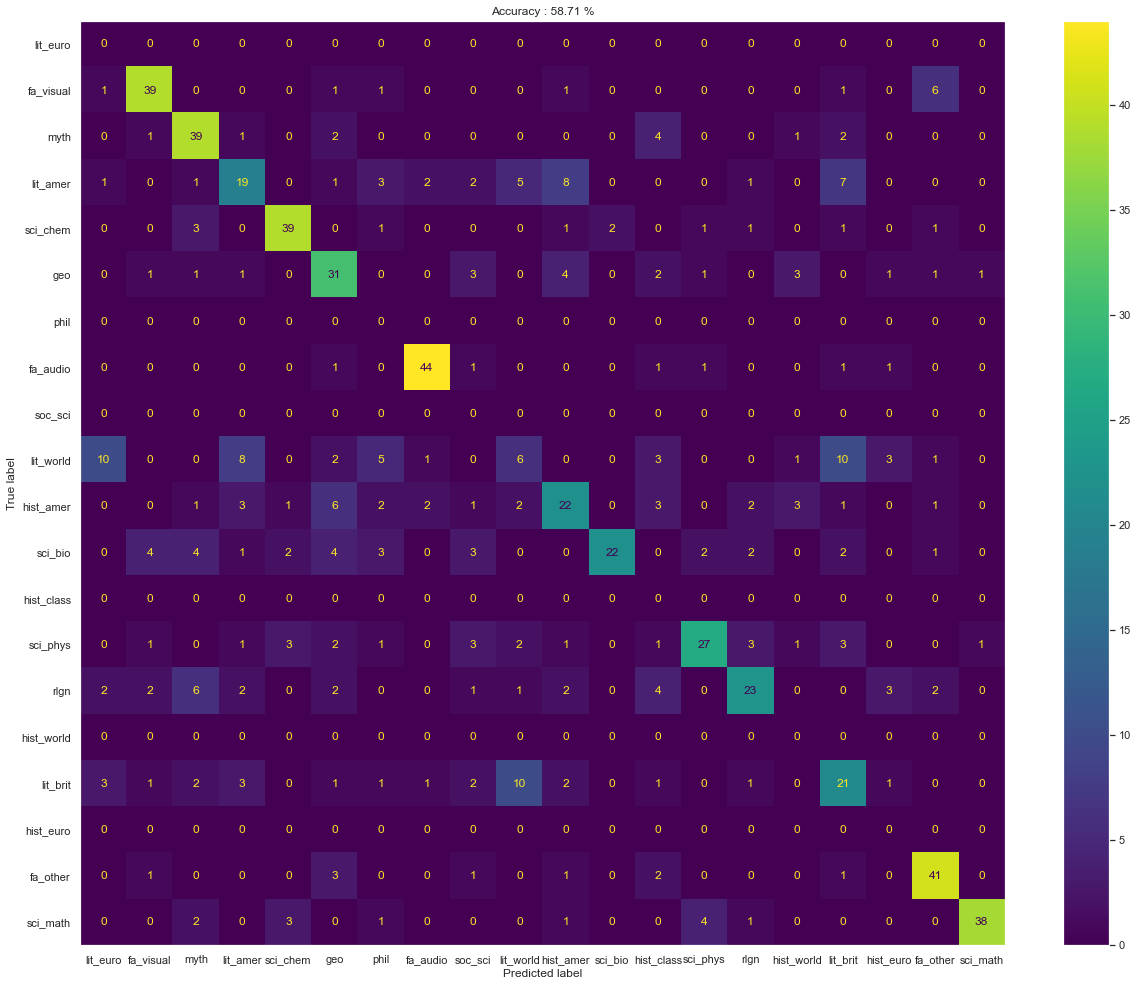

In [60]:
fig,ax = plt.subplots(1,1,figsize=(21, 17))
cmd=ConfusionMatrixDisplay(cm, display_labels=sub_class_names) 
cmd.plot(ax=ax)
plt.title("Accuracy : {} %".format(round(acc*100, 2)))
plt.grid(False)
plt.show()

In [61]:
for row_index, (input, prediction, label) in enumerate(zip (X, y_pred, y)):
  if prediction != label:
    print('Row', row_index, 'has been classified as', sub_class_index[int(prediction)], 'and should be', sub_class_index[int(label)])
    print('Questions: ' + input + '\n')

Row 3 has been classified as Social Science and should be Fine Arts: Audio
Questions: book william strunk white one influential prescriptive treatment english grammar u often required reading high school

Row 23 has been classified as History: Classical and should be Fine Arts: Audio
Questions: trumpeter became oldest person ever score single

Row 26 has been classified as Geography and should be Fine Arts: Audio
Questions: academy sometimes dubbed canoe

Row 30 has been classified as Science: Physics and should be Fine Arts: Audio
Questions: developed system composition

Row 41 has been classified as History: European and should be Fine Arts: Audio
Questions: pc performed every year royal albert hall

Row 45 has been classified as Literature: British and should be Fine Arts: Audio
Questions: character mikado lord high everything else

Row 50 has been classified as Fine Arts: Audio and should be History: American
Questions: american aviator first woman fly atlantic solo

Row 53 has bee

Row 539 has been classified as Literature: European and should be Religion
Questions: book hear paul escape damascus basket

Row 544 has been classified as Literature: American and should be Religion
Questions: many son job suffering

Row 545 has been classified as History: American and should be Religion
Questions: old caleb sent moses spy land

Row 546 has been classified as Mythology and should be Religion
Questions: abihail son name

Row 547 has been classified as History: Classical and should be Religion
Questions: zurishaddai belonged tribe

Row 548 has been classified as Fine Arts: Visual and should be Religion
Questions: saint homobonus patron saint

Row 555 has been classified as Fine Arts: Other and should be Fine Arts: Visual
Questions: g portraitist

Row 558 has been classified as History: American and should be Fine Arts: Visual
Questions: aw american pop artiste coined expression minute fame

Row 559 has been classified as Literature: British and should be Fine Arts: Visu

## Attempted Neural Network

In [62]:
# model = tf.keras.models.Sequential([              # model type
# #   tf.keras.layers.Flatten(input_shape=X_tr_VEC_ar.shape[1]),
#   tf.keras.layers.Dense(X_tr_VEC_ar.shape[1]),  # input layer
#   tf.keras.layers.Dense(100),
#   tf.keras.layers.Dense(3),                      # output to each class
#   tf.keras.layers.Softmax()                       # convert to probability
# ])
# #define our optimizer
# sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False, name='SGD')
# #
# model.compile(optimizer=sgd,
#               loss='categorical_crossentropy', #need to define our loss function
#               metrics=['accuracy'])

In [63]:
# epochs = 10
# batch_size = 100
# tstart = tf.timestamp()
# history = model.fit(X_tr_VEC_ar, y_tr, 
#                     epochs=epochs,
#                     batch_size=batch_size)
# total_time = tf.timestamp() - tstart
# print("total time %3.3f seconds"%total_time)

In [64]:
# model.summary()